In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
sns.set_theme(style='white', context='notebook', font_scale=1.33)

## Load parameters

In [2]:
weights = np.array([-1, 0, 1])
stan_model = '3pl_m2'

## Load StanFit.
f = os.path.join('stan_results', f'{stan_model}_summary.tsv')
params = read_csv(f, sep='\t', index_col=0)

def inv_logit(x):
    return 1 / (1 + np.exp(-x))

## Extract parameters.
beta  = params.T.filter(regex='beta\[').T['Mean'].values
alpha = params.T.filter(regex='alpha\[').T['Mean'].values
gamma = 0.25

mu = np.outer(weights, alpha) - beta
p = gamma + (1-gamma) * inv_logit(mu)
q = 1 - p

W = np.square(alpha) * (q / p) * np.square((p - gamma) / (1 - gamma))
W = W.T

### Assembly 1

This is an example to construct a single test.

In [ ]:
from mip import Model, xsum, maximize, BINARY

## Define metadata.
n_item = len(beta)
n_test = 12

## Initialize model.
model = Model("assembly")

## Initialize binary variables.
x = [model.add_var(var_type=BINARY) for i in range(n_item)]

## Define objective.
model.objective = maximize(xsum(x[i] * W[i].sum() for i in range(n_item)))

## Constraint #1: maximum number of items.
model += xsum(x[i] for i in range(n_item)) <= n_test

## Constraint #2: one item per family.
# for i in range(0,n_item,6): 
#     model += xsum(x[i:i+6]) <= 1
    
## Optimize.
model.optimize(max_seconds=120)

selected = np.array([i for i in range(n_item) if x[i].x >= 0.99])
print(selected)

In [ ]:
ax = sns.scatterplot(
    x=beta,
    y=alpha,
    hue=np.in1d(np.arange(n_item), selected)
)
ax.set(xlabel='difficulty', ylabel='discrimination')
sns.despine()

### Assembly 4a

In [ ]:
## Define indices.
triples = []
for i in range(0, n_item, 3):
    triple = list(range(i,i+3))
    for j in range(3): triples.append(np.roll(triple, j).tolist())
    
## Define metadata.
n_item = len(triples)
n_test = 12

## Initialize model.
model = Model("assembly")

## Initialize binary variables.
x = [model.add_var(var_type=BINARY) for i in range(n_item)]

## Define objective.
model.objective = maximize(xsum(x[i] * W[ix].sum() for i, ix in enumerate(triples)))

## Constraint #1: maximum number of triples.
model += xsum(x[i] for i in range(n_item)) <= n_test

## Constraint #2: one set per family.
for i in range(0,n_item,6): 
    model += xsum(x[i:i+6]) <= 1

## Optimize.
model.optimize(max_seconds=120)

selected = np.array([i for i in range(n_item) if x[i].x])
print(selected)

for i in range(3):
    ix = [triples[j][i] for j in selected]
    theta = np.linspace(-3,3,1001)
    mu = np.outer(theta, alpha[ix]) - beta[ix]
    p = gamma + (1-gamma) * inv_logit(mu)
    q = 1 - p
    I = np.square(alpha[ix]) * (q / p) * np.square((p - gamma) / (1 - gamma))
    plt.plot(theta, I.sum(axis=1))
plt.ylim(0,4);

In [ ]:
for i in range(3):
    print([triples[j][i] for j in selected])
    
sns.scatterplot(
    x=beta,
    y=alpha,
    hue =np.in1d(np.arange(n_item), np.concatenate([triples[i] for i in selected]))
)

### Assembly 4b

[ 52  77  93 125 129 147 191 245 292 305 327 357]


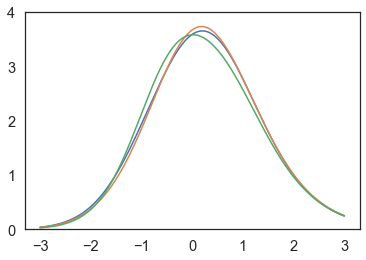

In [5]:
from mip import Model, xsum, maximize, BINARY

## Define indices.
triples = []
for i in range(0, len(beta), 3):
    triple = list(range(i,i+3))
    for j in range(3): triples.append(np.roll(triple, j).tolist())
    
## Define metadata.
n_item = len(triples)
n_test = 12
tol = 1e-2

## Initialize model.
model = Model("assembly")

## Initialize binary variables.
x = [model.add_var(var_type=BINARY) for i in range(n_item)]

## Define objective.
model.objective = maximize(xsum(x[i] * W[ix].sum() for i, ix in enumerate(triples)))

## Constraint #1: maximum number of triples.
model += xsum(x[i] for i in range(n_item)) <= n_test

## Constraint #2: one set per family.
for i in range(0,n_item,6): 
    model += xsum(x[i:i+6]) <= 1

## Constraint #3: minimize differences.
model += xsum(x[i] * W[j1].sum() for i, (j1,j2,j3) in enumerate(triples)) -\
         xsum(x[i] * W[j2].sum() for i, (j1,j2,j3) in enumerate(triples)) <= tol
model += xsum(x[i] * W[j2].sum() for i, (j1,j2,j3) in enumerate(triples)) -\
         xsum(x[i] * W[j1].sum() for i, (j1,j2,j3) in enumerate(triples)) <= tol
model += xsum(x[i] * W[j1].sum() for i, (j1,j2,j3) in enumerate(triples)) -\
         xsum(x[i] * W[j3].sum() for i, (j1,j2,j3) in enumerate(triples)) <= tol
model += xsum(x[i] * W[j3].sum() for i, (j1,j2,j3) in enumerate(triples)) -\
         xsum(x[i] * W[j1].sum() for i, (j1,j2,j3) in enumerate(triples)) <= tol
    
## Optimize.
model.optimize(max_seconds=120)

selected = np.array([i for i in range(n_item) if x[i].x])
print(selected)

for i in range(3):
    ix = [triples[j][i] for j in selected]
    theta = np.linspace(-3,3,1001)
    mu = np.outer(theta, alpha[ix]) - beta[ix]
    p = gamma + (1-gamma) * inv_logit(mu)
    q = 1 - p
    I = np.square(alpha[ix]) * (q / p) * np.square((p - gamma) / (1 - gamma))
    plt.plot(theta, I.sum(axis=1))
plt.ylim(0,4);

[53, 76, 93, 124, 129, 147, 190, 244, 293, 304, 327, 357]
[51, 77, 94, 125, 130, 148, 191, 245, 291, 305, 328, 358]
[52, 75, 95, 123, 131, 149, 189, 243, 292, 303, 329, 359]


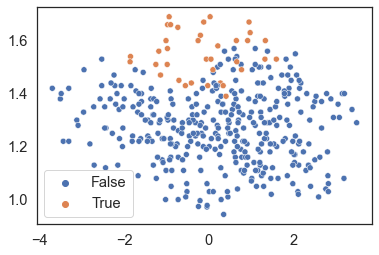

In [6]:
for i in range(3):
    print([triples[j][i] for j in selected])
    
sns.scatterplot(
    x=beta,
    y=alpha,
    hue =np.in1d(np.arange(n_item), np.concatenate([triples[i] for i in selected]))
);

0.17 -0.15
0.17 -0.11
0.25 -0.19


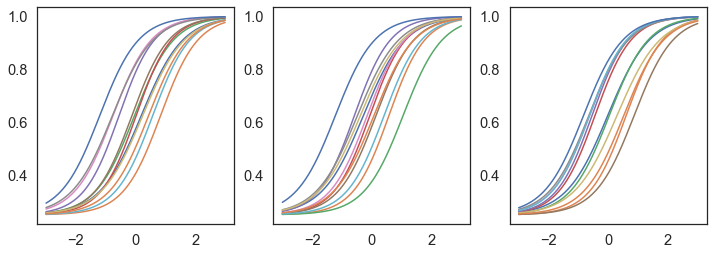

In [8]:
fig, axes = plt.subplots(1,3,figsize=(12,4))

for i, ax in enumerate(axes):
    ix = [triples[j][i] for j in selected]
    theta = np.linspace(-3,3,1001)
    mu = np.outer(theta, alpha[ix]) - beta[ix]
    p = gamma + (1-gamma) * inv_logit(mu)
    print(np.mean(p[theta==0] < 0.5).round(2), np.mean(beta[ix]).round(2))
    ax.plot(theta, p)


In [30]:
## Define indices.
triples = []
for i in range(0, n_item, 3):
    triple = list(range(i,i+3))
    for j in range(3): triples.append(np.roll(triple, j).tolist())
    
## Define metadata.
n_item = len(triples)
n_test = 12
tol = 1e-1

## Initialize model.
model = Model("assembly")

## Initialize binary variables.
x = [model.add_var(var_type=BINARY) for i in range(n_item)]

## Define objective.
model.objective = maximize(xsum(x[i] * W[ix].sum() for i, ix in enumerate(triples)))

## Constraint #1: maximum number of triples.
model += xsum(x[i] for i in range(n_item)) <= n_test

## Constraint #2: one set per family.
for i in range(0,n_item,6): 
    model += xsum(x[i:i+6]) <= 1

## Constraint #3: minimize differences.
for k in range(3):
    model += xsum(x[i] * W[j1,k] for i, (j1,j2,j3) in enumerate(triples)) -\
             xsum(x[i] * W[j2,k] for i, (j1,j2,j3) in enumerate(triples)) <= tol
    model += xsum(x[i] * W[j2,k] for i, (j1,j2,j3) in enumerate(triples)) -\
             xsum(x[i] * W[j1,k] for i, (j1,j2,j3) in enumerate(triples)) <= tol
    model += xsum(x[i] * W[j1,k] for i, (j1,j2,j3) in enumerate(triples)) -\
             xsum(x[i] * W[j3,k] for i, (j1,j2,j3) in enumerate(triples)) <= tol
    model += xsum(x[i] * W[j3,k] for i, (j1,j2,j3) in enumerate(triples)) -\
             xsum(x[i] * W[j1,k] for i, (j1,j2,j3) in enumerate(triples)) <= tol
        
## Optimize.
model.optimize(max_seconds=120)

selected = np.array([i for i in range(n_item) if x[i].x])
print(selected)

[ 53  76  93 124 130 148 190 243 293 303 329 357]


[1.94 3.64 2.71]
[1.95 3.56 2.73]
[2.02 3.63 2.65]


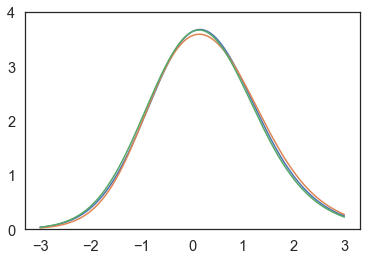

In [41]:
for i in range(3):
    ix = [triples[j][i] for j in selected]
    theta = np.linspace(-3,3,3001)
    mu = np.outer(theta, alpha[ix]) - beta[ix]
    p = gamma + (1-gamma) * inv_logit(mu)
    q = 1 - p
    I = np.square(alpha[ix]) * (q / p) * np.square((p - gamma) / (1 - gamma))
    plt.plot(theta, I.sum(axis=1))
    print(I[np.in1d(theta, [-1,0,1])].sum(axis=1).round(2))
plt.ylim(0,4);

array([2.02, 3.63, 2.65])

[52, 77, 93, 125, 131, 149, 191, 243, 292, 303, 328, 357]
[53, 75, 94, 123, 129, 147, 189, 244, 293, 304, 329, 358]
[51, 76, 95, 124, 130, 148, 190, 245, 291, 305, 327, 359]


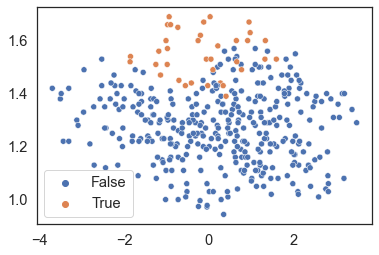

In [11]:
for i in range(3):
    print([triples[j][i] for j in selected])
    
sns.scatterplot(
    x=beta,
    y=alpha,
    hue =np.in1d(np.arange(n_item), np.concatenate([triples[i] for i in selected]))
);

0.17 -0.15
0.25 -0.08
0.17 -0.22


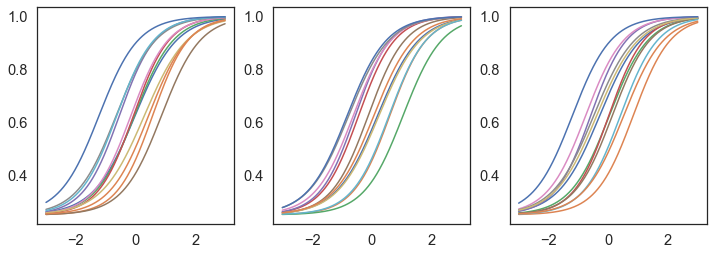

In [12]:
fig, axes = plt.subplots(1,3,figsize=(12,4))

for i, ax in enumerate(axes):
    ix = [triples[j][i] for j in selected]
    theta = np.linspace(-3,3,1001)
    mu = np.outer(theta, alpha[ix]) - beta[ix]
    p = gamma + (1-gamma) * inv_logit(mu)
    print(np.mean(p[theta==0] < 0.5).round(2), np.mean(beta[ix]).round(2))
    ax.plot(theta, p)
